In [1]:
#imports
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import ticker
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split 

2023-01-07 16:38:05.338704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 16:38:05.427345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/insa/lib:$LD_LIBRARY_PATH
2023-01-07 16:38:05.427364: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-07 16:38:07.405253: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot o

## Data Recovery

In [2]:
data = pd.read_csv('data_X_Y.csv', index_col = 0)

In [3]:
data

,Electricity demand,production_nette,production stock,index,Stored phs,Stored battery,Stored methanation,days,cost_phs,cost_bat,cost_met,cost,Stored24phs,Stored24battery,Stored24methanation,stock_day_phs,stock_day_battery,stock_day_methanation
0,822.34,-238.12,244.84,0,100.000000,100.000000,80.483619,1,0.000608,0.003235,0.003928,77.705064,100.000000,0.000000,77.484681,0.000000,-100.000000,-2.998938
1,1011.52,-230.66,253.92,24,100.000000,0.000000,77.484681,2,0.000608,0.003087,0.004208,79.031328,91.461111,0.000000,73.569996,-8.538889,0.000000,-3.914685
2,1429.34,40.22,114.61,48,91.461111,0.000000,73.569996,3,0.000608,0.003182,0.003103,68.930476,88.772222,35.554357,73.343739,-2.688889,35.554357,-0.226256
3,1476.76,-25.91,162.37,72,88.772222,35.554357,73.343739,4,0.000608,0.003113,0.003438,71.594721,81.144444,100.000000,71.943798,-7.627778,64.445643,-1.399942
4,1464.01,-233.79,284.44,96,81.144444,100.000000,71.943798,5,0.000608,0.003112,0.004489,82.088458,100.000000,100.000000,67.112806,18.855556,0.000000,-4.830992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,1395.76,-70.92,124.39,157536,71.872222,71.216617,86.169233,360,0.000608,0.003087,0.003327,70.220758,56.366667,78.041543,85.131638,-15.505556,6.824926,-1.037596
6565,1387.42,13.67,90.03,157560,56.366667,78.041543,85.131638,361,0.000608,0.003087,0.003486,71.809862,100.000000,100.000000,83.575204,43.633333,21.958457,-1.556433
6566,1421.66,-169.79,169.77,157584,100.000000,100.000000,83.575204,362,0.000608,0.003107,0.003430,71.457317,48.972222,86.080388,82.201024,-51.027778,-13.919612,-1.374180
6567,1401.63,-178.55,254.32,157608,48.972222,86.080388,82.201024,363,0.000608,0.003172,0.003719,74.990028,31.444444,42.230914,79.885016,-17.527778,-43.849474,-2.316009


### Ajout de 3 variables label :

- si on stock au max de notre capacité : 2
- si on destock au max de notre capacité : -2
- si on stock (pas au max) : 1
- si on destock (pas au max) : -1
- si on ne fait rien : 0

In [22]:
data['label_phs'] = 0
data['label_battery'] = 0
data['label_methanation'] = 0
for i in data.index:
    #### PHS
    if data.stock_day_phs.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_phs')), 1)
    if data.stock_day_phs.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_phs')), -1)
    if data.Stored24phs.loc[i] == 100 :
        data.loc.__setitem__((i, ('label_phs')), 2)
    if data.Stored24phs.loc[i] == 0 :
        data.loc.__setitem__((i, ('label_phs')), -2)
        
    #### Batterie
    if data.stock_day_battery.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_battery')), 1)
    if data.stock_day_battery.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_battery')), -1)
    if data.Stored24battery.loc[i] == 100:
        data.loc.__setitem__((i, ('label_battery')), 2)
    if data.Stored24battery.loc[i] == 0 :
        data.loc.__setitem__((i, ('label_battery')), -2)
    
    #### Methanation
    if data.stock_day_methanation.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_methanation')), 1)
    if data.stock_day_methanation.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_methanation')), -1)
    if data.Stored24methanation.loc[i] == 100 or data.stock_day_methanation.loc[i] >= 0.86 :
        data.loc.__setitem__((i, ('label_methanation')), 2)
    if data.Stored24methanation.loc[i] == 0 or data.stock_day_methanation.loc[i] <= -14 :
        data.loc.__setitem__((i, ('label_methanation')), -2)

In [23]:
data

,Electricity demand,production_nette,production stock,index,Stored phs,Stored battery,Stored methanation,days,cost_phs,cost_bat,...,cost,Stored24phs,Stored24battery,Stored24methanation,stock_day_phs,stock_day_battery,stock_day_methanation,label_phs,label_battery,label_methanation
0,822.34,-238.12,244.84,0,100.000000,100.000000,80.483619,1,0.000608,0.003235,...,77.705064,100.000000,0.000000,77.484681,0.000000,-100.000000,-2.998938,2,-2,-1
1,1011.52,-230.66,253.92,24,100.000000,0.000000,77.484681,2,0.000608,0.003087,...,79.031328,91.461111,0.000000,73.569996,-8.538889,0.000000,-3.914685,-1,-2,-1
2,1429.34,40.22,114.61,48,91.461111,0.000000,73.569996,3,0.000608,0.003182,...,68.930476,88.772222,35.554357,73.343739,-2.688889,35.554357,-0.226256,-1,1,-1
3,1476.76,-25.91,162.37,72,88.772222,35.554357,73.343739,4,0.000608,0.003113,...,71.594721,81.144444,100.000000,71.943798,-7.627778,64.445643,-1.399942,-1,2,-1
4,1464.01,-233.79,284.44,96,81.144444,100.000000,71.943798,5,0.000608,0.003112,...,82.088458,100.000000,100.000000,67.112806,18.855556,0.000000,-4.830992,2,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,1395.76,-70.92,124.39,157536,71.872222,71.216617,86.169233,360,0.000608,0.003087,...,70.220758,56.366667,78.041543,85.131638,-15.505556,6.824926,-1.037596,-1,1,-1
6565,1387.42,13.67,90.03,157560,56.366667,78.041543,85.131638,361,0.000608,0.003087,...,71.809862,100.000000,100.000000,83.575204,43.633333,21.958457,-1.556433,2,2,-1
6566,1421.66,-169.79,169.77,157584,100.000000,100.000000,83.575204,362,0.000608,0.003107,...,71.457317,48.972222,86.080388,82.201024,-51.027778,-13.919612,-1.374180,-1,-1,-1
6567,1401.63,-178.55,254.32,157608,48.972222,86.080388,82.201024,363,0.000608,0.003172,...,74.990028,31.444444,42.230914,79.885016,-17.527778,-43.849474,-2.316009,-1,-1,-1


In [24]:
# Volume max for phs, battery, methanation
volume= pd.Series([180 ,74.14, 12499.09])

# charging efficiency for phs, batetry, methanation
eta_in = pd.Series([0.95, 0.9, 0.59])
# discharging efficiency for phs, batetry, methanation
eta_out = pd.Series([0.9, 0.95, 0.45])

# Charging capacity phs, battery, methanation (for 1 hour)
S = pd.Series([9.3, 20.08, 7.66])
# discharging capacity phs, battery, methanation (for 1 hour)
Q = pd.Series([9.3, 20.08, 32.93])

# charging/discharging capacity in % for each tech and by day
S_p = [9.3*100*24/volume[0], 20.8*100*24/volume[1], 7.66*100*24/volume[2]]
Q_p = [9.3*100*24/volume[0], 20.08*100*24/volume[1], 32.93*100*24/volume[2]]
print('S % : ', S_p)
print('Q % : ', Q_p)

S % :  [124.00000000000001, 673.3207445373617, 1.4708270762111482]
Q % :  [124.00000000000001, 650.0134879956837, 6.3230203158789955]


## Constraint functions 
- We define 3 main constraints explained more precisely in repport and test it on simulted dataset.

##### 1. Constraint on storage technology level : cannot exceed installed capacity

In [25]:
# Stock level have to be <= 100 % and > 0
def C_level (Stored):
    #############################
    ## Stored is the level of stock for 1 technology in % (depending on Volume_tec)    
    #############################
    print('data where stock level < 0 :', Stored.loc[Stored < 0])
    print('data where stock level > 100 :', Stored.loc[Stored > 100])
    return Stored.loc[Stored < 0], Stored.loc[Stored > 100]

In [26]:
print('for phs : ')
C_level(data['Stored24phs'])
print('for battery : ')
C_level(data['Stored24battery'])
print('for metahanation : ')
C_level(data['Stored24methanation'])

# This constraint is perfectly respected

for phs : 
data where stock level < 0 : Series([], Name: Stored24phs, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24phs, dtype: float64)
for battery : 
data where stock level < 0 : Series([], Name: Stored24battery, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24battery, dtype: float64)
for metahanation : 
data where stock level < 0 : Series([], Name: Stored24methanation, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24methanation, dtype: float64)


(Series([], Name: Stored24methanation, dtype: float64),
 Series([], Name: Stored24methanation, dtype: float64))

##### 2. Contraint on quantity stored or deststock limited by residual production

In [27]:
def C_residualprod(RP,eta_in, eta_out, delta_stock, volume):
    ################################################
    # RP is the residual production : production_nette
    # eta_in Charging efficiency of phs (0), battery (1), methanation (2)
    # eta_out Disharging efficiency of phs (0), battery (1), methanation (2)
    # delta_stock = variation des stocks dans la journée
    # volume = volume max of each tec (useful to unpercent)
    
    # return index of problem
    ################################################   
    
    deltaphs = delta_stock[0]*volume[0]/100
    deltabat = delta_stock[1]*volume[1]/100
    deltamet = delta_stock[2]*volume[2]/100
    #if delta_stock > 0
    deltaphs[deltaphs>0] = deltaphs[deltaphs>0]/eta_in[0]
    deltabat[deltabat>0] = deltabat[deltabat>0]/eta_in[1]
    deltamet[deltamet>0] = deltamet[deltamet>0]/eta_in[2]
    # if delta_stock < 0
    deltaphs[deltaphs<0] = deltaphs[deltaphs<0]*eta_out[0]
    deltabat[deltabat<0] = deltabat[deltabat<0]*eta_out[1]
    deltamet[deltamet<0] = deltamet[deltamet<0]*eta_out[2]

    SUM = deltaphs + deltabat + deltamet
    
    # in all cases : each day, RP have to be lower than sum
    
    print('here there is a problem : ', RP[RP<SUM ], SUM[RP[RP<SUM].index])
    
    return  RP[RP<SUM], SUM[RP[RP<SUM].index], deltaphs, deltabat, deltamet

In [28]:
RP,SUM, simu_phs, simu_bat, simu_met = C_residualprod(data.production_nette,eta_in, eta_out, [data.stock_day_phs, data.stock_day_battery, data.stock_day_methanation], volume)

here there is a problem :  6      -411.95
7      -360.56
8      -327.13
11     -489.08
351    -546.39
         ...  
6213   -327.13
6216   -489.08
6556   -546.39
6562    448.87
6566   -169.79
Name: production_nette, Length: 138, dtype: float64 6      -411.897237
7      -360.558263
8      -327.091500
11     -489.055895
351    -546.372000
           ...    
6213   -327.091500
6216   -489.055895
6556   -546.372000
6562    448.898920
6566   -169.761000
Length: 138, dtype: float64


In [29]:
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())
# the difference between constraint rejected with most différence is quite hight
# We can consider this value as an acceptable difference

Maximum difference obseved :  0.08800000000019281


##### 3. Constraint on charging and discharging capacity : 
- we cannot charge or dischage more than a fix quantity each day.
- In fact this constraint is only for methanation.

In [30]:
def C_charging_discharging(S_p, Q_p, eta_in, eta_out, delta_stock):
    ###############################################################
    # S_p Charging capacity methanation
    # Q_p Discharging capacity of methanation (2)
    # eta_in Charging efficiency  methanation (2)
    # eta_out Discharging efficiency of  methanation (2)
    # delta_stock : contain daily delta stock for methanation
    
    # return index where there is a problem
    ###############################################################
    # case delta_stock[2] > 0
    delta_met_p = delta_stock[delta_stock>=0]
    print ('too much stockage for methanation : ', delta_met_p[delta_met_p>S_p*eta_in])
    
    
    delta_met_n = delta_stock[delta_stock < 0]
    print ('too much destockage for methanation : ', delta_met_n[delta_met_n < - Q_p/eta_out])
    
    # case delta_stock[2] < 0
    return  delta_met_p[delta_met_p>S_p*eta_in], delta_met_n[delta_met_n < -Q_p/eta_out]

C, D = C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], data.stock_day_methanation)

# error are q_ème surement probably round error 

too much stockage for methanation :  29      0.867823
48      0.867823
60      0.867823
107     0.867823
122     0.867823
          ...   
6550    0.867823
6552    0.867823
6553    0.867823
6561    0.867823
6562    0.867823
Name: stock_day_methanation, Length: 784, dtype: float64
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)


In [31]:
print('Theorical maximum methanation : ', S_p[2]*eta_in[2], 'Theorical minimum : ', -Q_p[2]/eta_out[2])
print ('Maximum observed (if upper) : ', C.max(), 'Minimum observed (if lower) : ', D.min())

# We conclude what it is probably round error not important

Theorical maximum methanation :  0.8677879749645774 Theorical minimum :  -14.051156257508879
Maximum observed (if upper) :  0.8678231775273417 Minimum observed (if lower) :  nan


## Données d'entrées (X) / de sorties (Y) du réseau

 - production_nette  $\sum_{str} production - demand$
 - Stored tec = stock level at the beggining of the day

In [32]:
X = data[['production_nette','Stored phs', 'Stored battery', 'Stored methanation', 'days' ]]
X

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-238.12,100.000000,100.000000,80.483619,1
1,-230.66,100.000000,0.000000,77.484681,2
2,40.22,91.461111,0.000000,73.569996,3
3,-25.91,88.772222,35.554357,73.343739,4
4,-233.79,81.144444,100.000000,71.943798,5
...,...,...,...,...,...
6564,-70.92,71.872222,71.216617,86.169233,360
6565,13.67,56.366667,78.041543,85.131638,361
6566,-169.79,100.000000,100.000000,83.575204,362
6567,-178.55,48.972222,86.080388,82.201024,363


In [33]:
Y = data[['label_phs', 'label_battery', 'label_methanation', 'cost']]
Y

,label_phs,label_battery,label_methanation,cost
0,2,-2,-1,77.705064
1,-1,-2,-1,79.031328
2,-1,1,-1,68.930476
3,-1,2,-1,71.594721
4,2,2,-1,82.088458
...,...,...,...,...
6564,-1,1,-1,70.220758
6565,2,2,-1,71.809862
6566,-1,-1,-1,71.457317
6567,-1,-1,-1,74.990028


### Entrance data normalisation

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = True
if scaler :
    scaler = StandardScaler()
    scaler.fit(X)
    XSc= scaler.transform(X)
    XSc = pd.DataFrame(XSc, index =X.index, columns = X.columns)
else : XSc = X.copy()

## Jeu de test et jeu d'entraînement

In [35]:
X_train,X_test,Y_train,Y_test = train_test_split(XSc,Y,test_size=0.25,random_state=13)

In [36]:
#pour partie stockage
# on ne peut pas mélanger 2 années sinon on a un problème avec predict continu
a = 0
b = 364


# surement mieux de mélanger les trains
X_train_strat = pd.concat([XSc[0:a], XSc[b:]] ) #utilisation des données renormalisées
X_test_strat = XSc[a:b]
Y_train_strat = pd.concat([Y[0:a], Y[b:]])
Y_test_strat = Y[a:b]
X_test_strat

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-1.476761,2.292299,2.714763,1.102883,-1.727299
1,-1.454558,2.292299,-0.587959,1.011628,-1.717782
2,-0.648339,2.007756,-0.587959,0.892507,-1.708265
3,-0.845162,1.918154,0.586302,0.885622,-1.698749
4,-1.463874,1.663972,2.714763,0.843022,-1.689232
...,...,...,...,...,...
359,-0.979125,1.354993,1.764128,1.275893,1.689232
360,-0.727360,0.838299,1.989536,1.244319,1.698749
361,-1.273391,2.292299,2.714763,1.196958,1.708265
362,-1.299463,0.591893,2.255037,1.155143,1.717782


## Modèles

In [37]:
#some useful methods

def compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly):
    model.compile(loss = loss,optimizer=optimiseur,metrics = metrics, loss_weights= loss_weights, run_eagerly = run_eagerly)
def train_model(model,X_train, Y_train, epoch, val):
    model.fit (X_train, Y_train, epochs = epoch, validation_split = val)
def train_model_funk(model, X_trainf, Y_trainf, epoch, val_data):
    model.fit (X_trainf, Y_trainf, epochs = epoch, validation_data = val_data)

In [38]:
def plot_pred ( Y_testr, predr ):
    fig0 = go.Figure()
    fig0.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_phs'], mode='lines', name = 'phs real'))
    fig0.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_phs'], mode='lines', name = 'phs predicted'))
    fig0.show()
    fig1 = go.Figure()
    fig1.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_battery'], mode='lines', name = 'battery real'))
    fig1.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_battery'], mode='lines', name = 'battery predicted'))
    fig1.show()
    fig2 = go.Figure()
    fig2.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_methanation'], mode='lines', name = 'methanation real'))
    fig2.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_methanation'], mode='lines', name = 'methanation predicted'))
    fig2.show()
    fig3 = go.Figure()
    fig3.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['cost'], mode='lines', name = 'cost real * 10000'))
    fig3.add_traces(go.Scatter(x = predr.index, y = predr['cost'], mode='lines', name = 'cost predicted *10000'))
    fig3.show()
    print('total cost real :', np.sum(Y_testr['cost'])/10000)
    print('total cost predicted :', np.sum(predr['cost'])/10000)

### 1/ Premier modèle construction "classique"

In [45]:
def build_model1(input_size, output_size):
    model = keras.Sequential([
    layers.Dense(128, activation = 'relu', input_shape = input_size),
    layers.Dropout(0.3, seed = 2),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(output_size)])
    return model

In [49]:
Y_train

,label_phs,label_battery,label_methanation,cost
995,-2,-2,2,67.043640
641,-1,-2,-1,71.568588
3411,-1,-1,1,68.744010
3554,1,1,1,68.065500
849,1,-2,2,67.043640
...,...,...,...,...
868,1,-2,2,67.590060
2797,1,1,2,68.299860
74,1,1,1,67.314750
6337,1,1,1,67.675950


In [57]:
input_size = [X_train.shape[1]]
output_size = Y_train.shape[1]
lr = 0.05
loss = tf.keras.losses.CategoricalCrossentropy()
optimiseur = tf.keras.optimizers.Adam()
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_1 = build_model1 (input_size, output_size)
model_1.summary()
model = model_1
compile_model(model, lr,loss, optimiseur, metrics,  loss_weights, run_eagerly)
train_model(model,X_train, Y_train, epoch, val)
print("Score jeu test : [loss, accuracy]", model_1.evaluate(X_test,Y_test))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               768       
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               16512     
                                                                 
 dense_47 (Dense)            (None, 128)               16512     
                                                                 
 dense_48 (Dense)            (None, 128)               16512     
                                                                 
 dense_49 (Dense)            (None, 128)               16512     
                                                                 
 dense_50 (Dense)            (None, 4)                

In [58]:
model_1.evaluate(X_test, Y_test)

52/52 [==============================] - 0s 894us/step - loss: 737.2464 - accuracy: 1.0000


[737.2463989257812, 1.0]

##### Predictions

In [59]:
pred_1 = pd.DataFrame(model_1.predict(X_test))
pred_1.columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation','cost']
pred_1.index = Y_test.index
pred_1

52/52 [==============================] - 0s 841us/step


,stock_day_phs,stock_day_battery,stock_day_methanation,cost
3724,-0.887297,0.260989,-1.125175,1.463605
4454,-0.776390,0.491764,-1.304464,1.706022
3188,-0.514931,0.257282,-0.863899,1.125341
6115,-0.458471,0.220923,-0.748566,0.959765
139,-0.589419,0.317046,-0.963838,1.211882
...,...,...,...,...
4296,-0.569013,0.241168,-0.903914,1.117591
6104,-0.448311,0.243438,-0.749713,0.992342
6172,-0.560252,0.292144,-0.924218,1.188932
1933,-0.840624,0.231922,-1.057482,1.366130


# Etude d'un stratégie de stockage

## Test des modèles sur des prédictions consécutives (Réalisable ?)

- on coupe X_train et Ytrain à la main de manière à prédire sur une période contigue de l'année : ici l'an 2000. On apprend sur l'autre partie de l'année

#### Prédiction contigue de la stratégie de stockage 

- l'idée est de prédire le stockage en fin de journée j+1 à partir des valeurs prédites en fin de journée j
- ensuite il faut vérifier les contraintes de notre problème.

In [60]:
X_train_strat
X_train_strat = X_train_strat.sample(frac = 1, random_state=13)
Y_train_strat = Y_train_strat.sample(frac = 1, random_state=13)

In [64]:
round(1.8)

2

In [44]:
def pred_conti(model, Y_test, X, a, b):

    pred2 = pd.DataFrame([], columns = Y_test.columns)
    simu = X[a:b] #input avant sclalerisation !!! meme indice que le X_test_strat
    print(simu)
    for i in range(a,b):
        sim = pd.DataFrame([simu.iloc[i]], columns = X.columns)
        if scaler:
            simSC = scaler.transform(sim)
        else : simSC = sim
        simds = pd.DataFrame(simSC, columns = X.columns)
        #print(simds)
        pred = model.predict(simds)
        
        energie_dispo = simu.at[i, 'production_residuelle']
        #on stocke en methanation
        if round(pred[0][2]) == -2 :
            
            
        
        
        
        
        
        
        new_row = pd.Series({'stock_day_phs': pred[0][0], 'stock_day_battery': pred[0][1], 'stock_day_methanation' : pred[0][2], 'cost': pred[0][3]})
        pred2 = pd.concat([pred2, new_row.to_frame().T], ignore_index=True)
        #update of level of stock for to start next day prediction
        #print(simu.at[i,'Stored phs'])
        simu.at[i+1, 'Stored phs'] = min(simu.at[i,'Stored phs'] + pred[0][0],100)
        simu.at[i+1, 'Stored battery'] = min(simu.at[i,'Stored battery'] + pred[0][1],100)
        simu.at[i+1, 'Stored methanation'] = min(simu.at[i,'Stored methanation'] + pred[0][2]/7.,100)
    return pred2, simu

### Strat modèle 2 

Il faut faire réaprendre le modèle car les jeux de test/ train sont différents pour la stratégie

In [89]:
input_size = X_train.shape[1]
lr = 0.001
loss = tf.keras.losses.MeanSquaredError()
optimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_2 = build_model2 (input_size)
model_2.summary()
model = model_2
compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly)
train_model(model,X_train_strat, Y_train_strat, epoch, val)
print("Score jeu test : [loss, accuracy]", model_2.evaluate(X_test_strat,Y_test_strat))

Model: "model_Sigmoid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 128)          768         ['input_4[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_36[0][0]']               
                                                                                                  
 dense_37 (Dense)               (None, 128)          16512       ['dropout_4[0][0]']              
                                                                                      

In [90]:
a = 0
b = 363
pred2, simu = pred_conti(model_2, Y_test_strat,X, a, b)
pred2

     production_nette  Stored phs  Stored battery  Stored methanation  days
0             -238.12  100.000000      100.000000           80.483619     1
1             -230.66  100.000000      100.000000           76.899550     2
2               40.22  100.000000      100.000000           73.503083     3
3              -25.91  100.000000      100.000000           73.208742     4
4             -233.79  100.000000      100.000000           72.390386     5
..                ...         ...             ...                 ...   ...
358           -374.13   89.410971       89.549076           94.777476   359
359            -70.92   56.365046       38.176052           90.436253   360
360             13.67   38.504204       35.567464           90.538740   361
361           -169.79   31.351872       31.466077           91.406528   362
362           -178.55   10.956399       14.410664           90.060844   363

[363 rows x 5 columns]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


/tmp/ipykernel_7965/847985222.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,9.921089,-2.752439,-36.172695,80.072266
1,9.842697,-3.248396,-34.048069,79.136513
2,19.737928,0.120201,-9.919287,72.146133
3,17.407454,-1.613638,-13.582079,72.691528
4,8.667314,-4.621555,-31.750092,78.022026
...,...,...,...,...
358,-25.136223,-51.072483,-24.093161,76.955154
359,-9.178991,-6.035964,1.449108,66.596474
360,-1.206465,3.649576,6.074516,66.767097
361,-15.878810,-18.553177,-6.049283,67.790558


In [91]:
pred2

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,9.921089,-2.752439,-36.172695,80.072266
1,9.842697,-3.248396,-34.048069,79.136513
2,19.737928,0.120201,-9.919287,72.146133
3,17.407454,-1.613638,-13.582079,72.691528
4,8.667314,-4.621555,-31.750092,78.022026
...,...,...,...,...
358,-25.136223,-51.072483,-24.093161,76.955154
359,-9.178991,-6.035964,1.449108,66.596474
360,-1.206465,3.649576,6.074516,66.767097
361,-15.878810,-18.553177,-6.049283,67.790558


In [92]:
Y_test_strat

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,0.000000,-100.000000,-20.992568,77.705064
1,-8.538889,0.000000,-27.402795,79.031328
2,-2.688889,35.554357,-1.583795,68.930476
3,-7.627778,64.445643,-9.799593,71.594721
4,18.855556,0.000000,-33.816942,82.088458
...,...,...,...,...
359,-15.505556,6.824926,-7.263169,70.220758
360,43.633333,21.958457,-10.895033,71.809862
361,-51.027778,-13.919612,-9.619260,71.457317
362,-17.527778,-43.849474,-16.212060,74.990028


In [93]:
plot_pred(Y_test_strat, pred2)

total cost real : 2.5106933973718513
total cost predicted : 2.59230390625


In [94]:
pred2

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,9.921089,-2.752439,-36.172695,80.072266
1,9.842697,-3.248396,-34.048069,79.136513
2,19.737928,0.120201,-9.919287,72.146133
3,17.407454,-1.613638,-13.582079,72.691528
4,8.667314,-4.621555,-31.750092,78.022026
...,...,...,...,...
358,-25.136223,-51.072483,-24.093161,76.955154
359,-9.178991,-6.035964,1.449108,66.596474
360,-1.206465,3.649576,6.074516,66.767097
361,-15.878810,-18.553177,-6.049283,67.790558


In [95]:
print('methanation : ')
C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], pred2.stock_day_methanation / 7.)

methanation : 
too much stockage for methanation :  9     8.614340
10    7.383719
Name: stock_day_methanation, dtype: float32
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float32)


(9     8.614340
 10    7.383719
 Name: stock_day_methanation, dtype: float32,
 Series([], Name: stock_day_methanation, dtype: float32))

In [96]:
if scaler : 
    X_pred2 = scaler.inverse_transform(X_test_strat)
else : X_pred2 = X_test_strat
X_pred2 = pd.DataFrame(X_pred2, columns = ['production_nette', 'Stored phs', 'Stored battery',
       'Stored methanation', 'days'])
X_pred2

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-238.12,100.000000,100.000000,80.483619,1.0
1,-230.66,100.000000,0.000000,77.484681,2.0
2,40.22,91.461111,0.000000,73.569996,3.0
3,-25.91,88.772222,35.554357,73.343739,4.0
4,-233.79,81.144444,100.000000,71.943798,5.0
...,...,...,...,...,...
359,-70.92,71.872222,71.216617,86.169233,360.0
360,13.67,56.366667,78.041543,85.131638,361.0
361,-169.79,100.000000,100.000000,83.575204,362.0
362,-178.55,48.972222,86.080388,82.201024,363.0


In [97]:
pred2['stock_day_methanation'] = pred2['stock_day_methanation']/7
pred2

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,9.921089,-2.752439,-5.167528,80.072266
1,9.842697,-3.248396,-4.864010,79.136513
2,19.737928,0.120201,-1.417041,72.146133
3,17.407454,-1.613638,-1.940297,72.691528
4,8.667314,-4.621555,-4.535728,78.022026
...,...,...,...,...
358,-25.136223,-51.072483,-3.441880,76.955154
359,-9.178991,-6.035964,0.207015,66.596474
360,-1.206465,3.649576,0.867788,66.767097
361,-15.878810,-18.553177,-0.864183,67.790558


In [98]:
RP,SUM, phsc, batc, metc = C_residualprod(X_pred2.production_nette[:-1],eta_in, eta_out, [pred2.stock_day_phs, pred2.stock_day_battery, pred2.stock_day_methanation], volume)

here there is a problem :  5     -370.12
6     -411.95
7     -360.56
8     -327.13
9     -735.18
        ...  
358   -374.13
359    -70.92
360     13.67
361   -169.79
362   -178.55
Name: production_nette, Length: 143, dtype: float64 5      -350.483368
6      -367.364868
7      -309.953094
8      -265.653137
9      1788.711914
          ...     
358    -270.284210
359      24.734745
360     184.891983
361     -87.397995
362     -93.654297
Length: 143, dtype: float32


In [99]:
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())

Maximum difference obseved :  2523.8919140625


In [100]:
print('for phs : ')
C_level(simu['Stored phs'])
print('for battery : ')
C_level(simu['Stored battery'])
print('for metahanation : ')
C_level(simu['Stored methanation'])

for phs : 
data where stock level < 0 : Series([], Name: Stored phs, dtype: float64)
data where stock level > 100 : Series([], Name: Stored phs, dtype: float64)
for battery : 
data where stock level < 0 : Series([], Name: Stored battery, dtype: float64)
data where stock level > 100 : Series([], Name: Stored battery, dtype: float64)
for metahanation : 
data where stock level < 0 : Series([], Name: Stored methanation, dtype: float64)
data where stock level > 100 : Series([], Name: Stored methanation, dtype: float64)


(Series([], Name: Stored methanation, dtype: float64),
 Series([], Name: Stored methanation, dtype: float64))

In [101]:
def show_simu(start,finish,d):
    col = {"production_nette" : "#00FFFF", "phs" : "#DDC79E", "battery" : "#EC9AC8", "methanation": "#9AECC2"}
    tec = []
    stor = ["phs","battery","methanation"]

    Volume = pd.Series([180 ,74.14, 12499.09])

    x = "phs"

    tec_aux = tec
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = np.arange(start,finish)
    ymin, ymax = -760,1445
    #ymin, ymax= 0,50
    fig2, axs2 = plt.subplots(1, figsize = (15,5))
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        print(i)
        sum_s += d["storage_" + i][h]
    for s in stor[::-1]:
        aux = "storage_" + s
        axs2.fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs2.fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs2.plot(h, d["production_nette"][h], color = 'black' , label = "residual production",linewidth= 2)

    axs2.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    axs2.set_ylabel("Energy volume (GWh)")
    axs2.set_ylim(ymin,ymax)
    axs2.legend(loc ="upper right")
    axs2.set_title("Hours "+ str(start)+" to "+str(finish))

In [81]:
X_pred2.min()

production_nette     -735.18
Stored phs              0.00
Stored battery          0.00
Stored methanation      0.00
days                    1.00
dtype: float64

In [82]:
df = pred2.merge(X_pred2[:-1],right_index = True, left_index = True)
df['storage_phs']=phsc
df['storage_battery']=batc
df['storage_methanation']=metc
#df


phs
battery
methanation


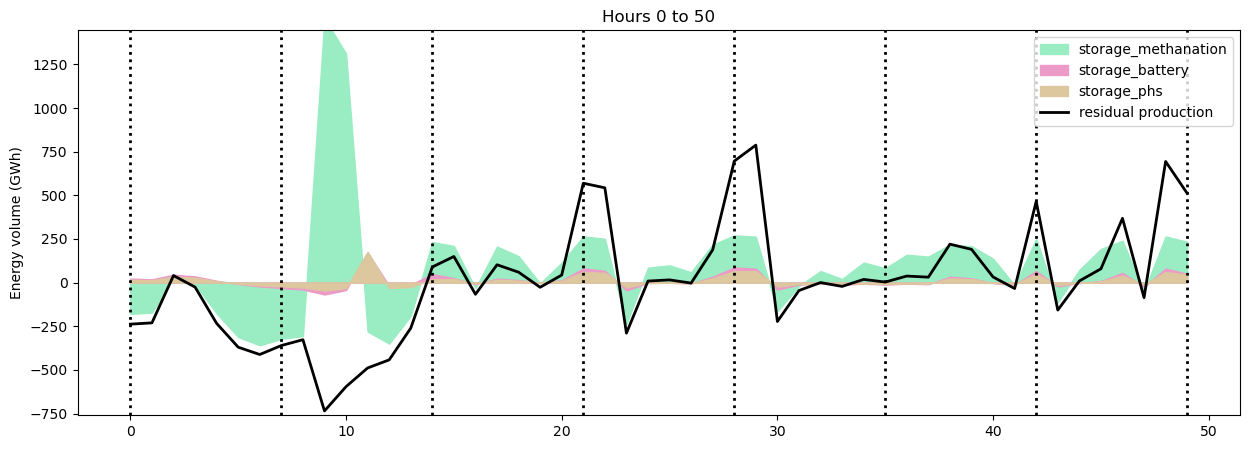

In [83]:
show_simu(0,50,df)

phs
battery
methanation


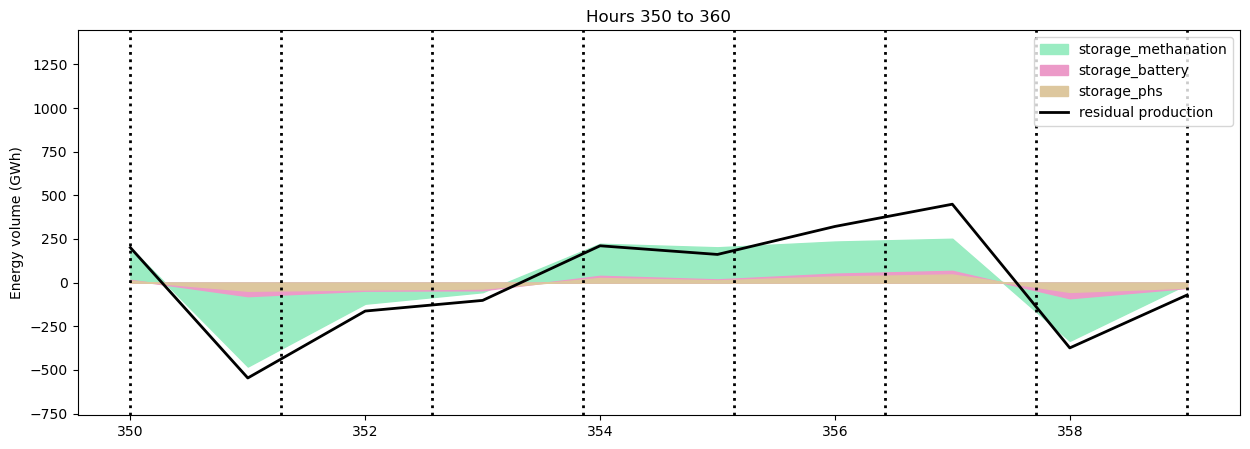

In [84]:
show_simu(350,360,df)

In [85]:
df_simu = data.copy()
df_simu['storage_phs']=simu_phs
df_simu['storage_battery']=simu_bat
df_simu['storage_methanation']=simu_met

phs
battery
methanation


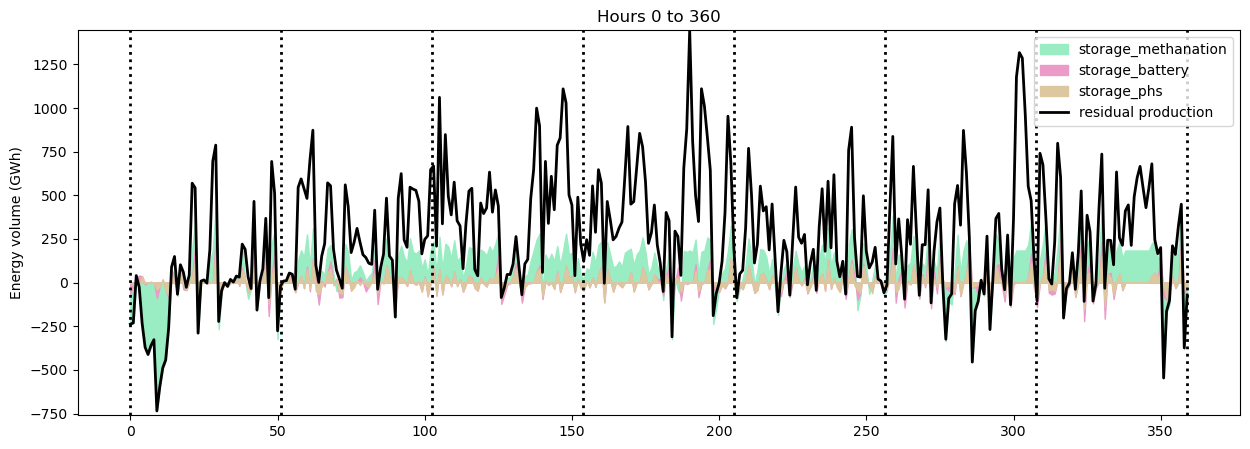

In [86]:
show_simu(0,360,df_simu)

phs
battery
methanation


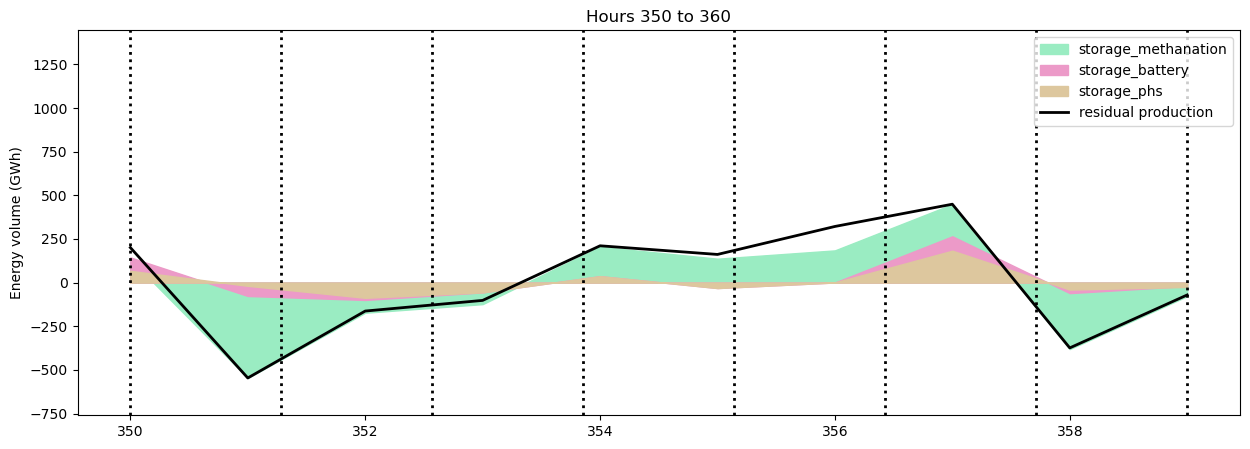

In [87]:
show_simu(350,360,df_simu)

In [66]:
''''import plotly.graph_objects as go

def show_simu(start,finish,d):
    col = {"production_nette" : "#00FFFF", "phs" : "#DDC79E", "battery" : "#EC9AC8", "methanation": "#9AECC2"}
    tec = []
    stor = ["phs","battery","methanation"]

    Volume = pd.Series([180 ,74.14, 12499.09])

    x = "phs"

    tec_aux = tec
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = np.arange(start,finish)
    ymin, ymax = -700,1445
    #ymin, ymax= 0,50
    
    fig = go.Figure()
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        print(i)
        sum_s += d["stock_day_" + i][h]
    for s in stor[::-1]:
        aux = "stock_day_" + s
        fig.add_trace(go.Scatter(
            x=h,
            y=aux,
            mode='lines',
            name='Demand',
            line=dict(color=col[s], width=4)
        )
        )
        sum_s -= d[aux][h]

    # Demande
    fig.add_trace(go.Scatter(
        x=h,
        y=d["production_nette"][h],
        mode='lines',
        name='Demand',
        line=dict(color='black', width=4)
    ))

    # Vertical lines
    for x_val in np.linspace(h[0],h[-1],8):
        fig.add_shape(
            type='line',
            x0=x_val,
            y0=ymin,
            x1=x_val,
            y1=ymax,
            yref='paper',
            line=dict(color='black', width=2, dash='dot')
        )
    
    fig.update_layout(
        yaxis=dict(
            title='Energy volume (GWh)',
            range=[ymin, ymax]
        ),
        #shapes=list(fig.shape),
        title=f"Hours {start} to {finish}"
    )
    fig.show()
    '''
      h  = np.arange(start,finish)
    ymin, ymax = -700,1445
    #ymin, ymax= 0,50
    fig2, axs2 = plt.subplots(1, figsize = (15,5))
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        print(i)
        sum_s += d["stock_day_" + i][h]
    for s in stor[::-1]:
        aux = "stock_day_" + s
        axs2.fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs2.fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs2.plot(h, d["production_nette"][h], color = 'black' , label = "Demand",linewidth= 4)

    axs2.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    axs2.set_ylabel("Energy volume (GWh)")
    axs2.set_ylim(ymin,ymax)
    axs2.legend(loc ="upper right")
    axs2.set_title("Hours "+ str(start)+" to "+str(finish))
'''''''

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 71)

In [ ]:
''''show_simu(1,360,df)''''